# Conduct a force controlled analysis of a uniaxial material

Author: Maxim Millen
 
Note: The force controlled uniaxial driver has been implemented as a function in the Object-oriented OpenSEES library, 
o3seespy (`o3seespy.tools.run_uniaxial_force_driver()`) and displacement 
controlled (`o3seespy.tools.run_uniaxial_disp_driver()`)


### Load inline plotting and auto-reload commands

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Load the libraries needed for the analysis

In [6]:
import matplotlib.pyplot as plt
import engformat as ef
import numpy as np
import o3seespy as o3
import o3seespy.__about__
print('o3seespy version: ', o3seespy.__about__.__version__)

o3seespy version:  3.1.0.18


## Define properties for SteelMPF material and forces

In [3]:
fy = 1450  # N
k = 5e4  # N/m
el_y = fy / k
b = 0.001

forces = np.array([1200, -10, 1400, 300, 800])  # N


## Run a uniaxial driver

In [4]:
# control parameters
d_step = 0.0001
max_steps=10000
handle='silent'

osi = o3.OpenSeesInstance(ndm=1)

left_node = o3.node.Node(osi, 0, 0)
right_node = o3.node.Node(osi, 0, 0)
o3.Fix1DOF(osi, left_node, o3.cc.FIXED)
o3.Fix1DOF(osi, right_node, o3.cc.FREE)

mat_obj = o3.uniaxial_material.SteelMPF(osi, fy, fy, k, b, b, 
                                        r0=10, c_r1=0.99, c_r2=0.15)
ele = o3.element.ZeroLength(osi, [left_node, right_node], mats=[mat_obj], dirs=[o3.cc.DOF2D_X], r_flag=1)

o3.constraints.Plain(osi)
o3.numberer.RCM(osi)
o3.system.BandGeneral(osi)
o3.test_check.NormDispIncr(osi, 0.002, 10, p_flag=0)
o3.algorithm.Newton(osi)
o3.integrator.DisplacementControl(osi, right_node, o3.cc.X, 0.0001)
o3.analysis.Static(osi)
ts_po = o3.time_series.Linear(osi, factor=1)
o3.pattern.Plain(osi, ts_po)
o3.Load(osi, right_node, [1.0])

react = 0
disp = [0]
reacts = [react]

diffs = np.diff(forces, prepend=0)
orys = np.where(diffs >= 0, 1, -1)
for i in range(len(forces)):
    ory = orys[i]
    o3.integrator.DisplacementControl(osi, right_node, o3.cc.X, -d_step * ory)
    for j in range(max_steps):
        if react * ory < forces[i] * ory:
            o3.analyze(osi, 1)
        else:
            break
        o3.gen_reactions(osi)
        react = o3.get_ele_response(osi, ele, 'force')[0]
        reacts.append(react)
        end_disp = -o3.get_node_disp(osi, right_node, dof=o3.cc.X)
        disp.append(end_disp)
    if j == max_steps - 1:
        if handle == 'silent':
            break
        if handle == 'warn':
            print(f'Target not met: force={react:.4g}, target: {forces[i]:.4g}')
        else:
            raise ValueError()
disp = np.array(disp)
reacts = np.array(reacts)


## Plot results

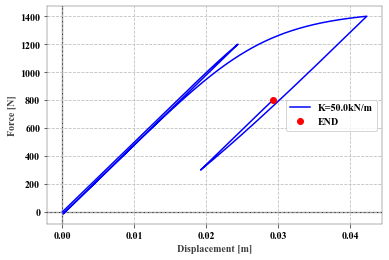

In [5]:

bf, sps = plt.subplots()
sps.plot(disp, reacts, label=f'K={k/1e3}kN/m', c='b')
sps.plot(disp[-1], reacts[-1], 'o', c='r', label='END')
sps.legend()
ef.xy(sps, y_axis=1, x_axis=1, x_grid=True, y_grid=True)
sps.set_xlabel('Displacement [m]')
sps.set_ylabel('Force [N]')
plt.show()